<a href="https://colab.research.google.com/github/AshikSathiya/Cirrhosis-Prediction/blob/main/Cirrhosis_Prediction_Dataset_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cirrhosis Prediction Dataset Modeling
Ashik Sathiya


---



In [1]:
#Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Plots
import seaborn as sns
import matplotlib.pyplot as plt

#Scores
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

#Data Leakage
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer



#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Feature Engineering
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout


from sklearn import set_config
set_config(transform_output='pandas')

#Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load Dataset
fpath = '/content/drive/MyDrive/CodingDojo/Project 2/cleaned_cirrhosis.csv'
df = pd.read_csv(fpath)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age_Years                 418 non-null    float64
 1   Years_Since_Registration  418 non-null    float64
 2   Status                    418 non-null    object 
 3   Drug                      312 non-null    object 
 4   Sex                       418 non-null    object 
 5   Ascites                   312 non-null    object 
 6   Hepatomegaly              312 non-null    object 
 7   Spiders                   312 non-null    object 
 8   Edema                     418 non-null    object 
 9   Bilirubin                 418 non-null    float64
 10  Cholesterol               418 non-null    int64  
 11  Albumin                   418 non-null    float64
 12  Copper                    418 non-null    int64  
 13  Alk_Phos                  418 non-null    float64
 14  SGOT_Level

,Age_Years,Years_Since_Registration,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT_Levels,Tryglicerides,Platelets,Prothrombin,Stage
0,58.765229,1.095140,D,D-penicillamine,F,Y,Y,Y,Y,14.5,261,2.60,156,1718.0,137.95,172.0,190,12.2,4
1,56.446270,12.320329,C,D-penicillamine,F,N,Y,Y,N,1.1,302,4.14,54,7394.8,113.52,88.0,221,10.6,3
2,70.072553,2.770705,D,D-penicillamine,M,N,N,N,S,1.4,176,3.48,210,516.0,96.10,55.0,151,12.0,4
3,54.740589,5.270363,D,D-penicillamine,F,N,Y,Y,S,1.8,244,2.54,64,6121.8,60.63,92.0,183,10.3,4
4,38.105407,4.117728,CL,Placebo,F,N,Y,Y,N,3.4,279,3.53,143,671.0,113.15,72.0,136,10.9,3


#Set Target

In [4]:
# Create features matrix and target vector
X = df.drop(columns = ['Stage','Drug'])
y = df['Stage']

#Feature Engineering

In [5]:
df['Stage'].value_counts()

3    155
4    144
2     92
1     21
0      6
Name: Stage, dtype: int64

We will combine Stage 0 to Stage 1

In [6]:
df['Stage'] = df['Stage'].replace(0, 1)


In [7]:
df['Stage'].value_counts()

3    155
4    144
2     92
1     27
Name: Stage, dtype: int64

#Split DataSet

In [8]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)

#Create Column Transformer

In [9]:
#View all numeric columns and save to num col
num_col = X_train.select_dtypes("number").columns
X_train[num_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 336 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age_Years                 334 non-null    float64
 1   Years_Since_Registration  334 non-null    float64
 2   Bilirubin                 334 non-null    float64
 3   Cholesterol               334 non-null    int64  
 4   Albumin                   334 non-null    float64
 5   Copper                    334 non-null    int64  
 6   Alk_Phos                  334 non-null    float64
 7   SGOT_Levels               334 non-null    float64
 8   Tryglicerides             334 non-null    float64
 9   Platelets                 334 non-null    int64  
 10  Prothrombin               334 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 31.3 KB


In [10]:
 # Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)




# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)


# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index(['Status', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')
Numeric Columns: Index(['Age_Years', 'Years_Since_Registration', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT_Levels', 'Tryglicerides',
       'Platelets', 'Prothrombin'],
      dtype='object')


In [11]:
# Fit on training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age_Years', 'Years_Since_Registration', 'Bilirubin', 'Cholesterol',
       'Albumin', 'Copper', 'Alk_Phos', 'SGOT_Levels', 'Tryglicerides',
       'Platelets', 'Prothrombin'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Status', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

In [12]:
# Transform the training data
X_train_processed = preprocessor.transform(X_train)
# Transform the testing data
X_test_processed = preprocessor.transform(X_test)


In [13]:
X_test_processed.head()

,Age_Years,Years_Since_Registration,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT_Levels,Tryglicerides,Platelets,...,Ascites_Y,Hepatomegaly_Missing,Hepatomegaly_N,Hepatomegaly_Y,Spiders_Missing,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
321,1.246246,0.075137,-0.458252,-0.988793,0.451296,-0.905697,-0.762412,-1.340890,-1.087195,-1.080482,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
324,-1.588149,2.692442,-0.293650,-0.988793,-0.617563,-0.905697,-0.762412,-1.340890,-1.087195,-2.398813,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
388,1.529763,-0.329117,-0.552310,-0.988793,-1.045107,-0.905697,-0.762412,-1.340890,-1.087195,-0.833888,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
56,0.260920,1.270034,-0.176077,0.008290,-0.760078,2.055493,5.253974,0.238949,0.092999,-0.350184,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
153,1.754300,-1.683835,-0.152563,-0.344524,-2.232728,1.978579,-0.201176,0.464768,-0.145551,-1.374498,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


#Default Models

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

##KNN

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.70      0.39      0.50        18
           2       0.53      0.67      0.59        76
           3       0.64      0.71      0.67       123
           4       0.78      0.65      0.71       113

    accuracy                           0.65       334
   macro avg       0.53      0.48      0.50       334
weighted avg       0.66      0.65      0.65       334



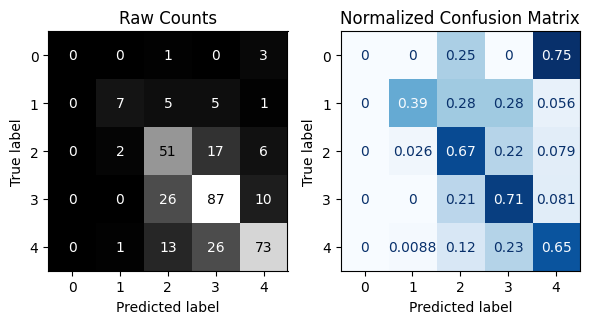

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.21      0.19      0.20        16
           3       0.43      0.59      0.50        32
           4       0.67      0.52      0.58        31

    accuracy                           0.45        84
   macro avg       0.26      0.26      0.26        84
weighted avg       0.45      0.45      0.44        84



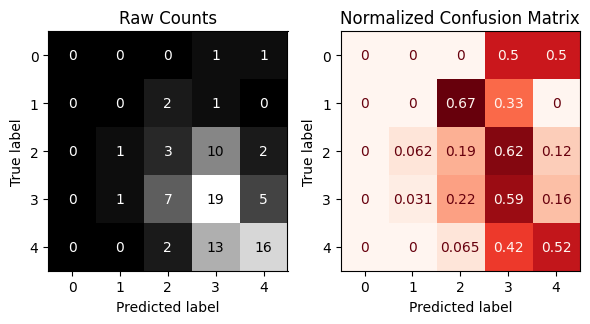

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Instantiate default KNN
knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train)
evaluate_classification(knn, X_train_processed, y_train, X_test_processed, y_test)

###Tuning

In [16]:
# Making every other value from the range (odd values)
nneighbors_list = list(range(1,41,2))
nneighbors_list

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]

In [17]:
# Get list of params to tune
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00       123
           4       1.00      1.00      1.00       113

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



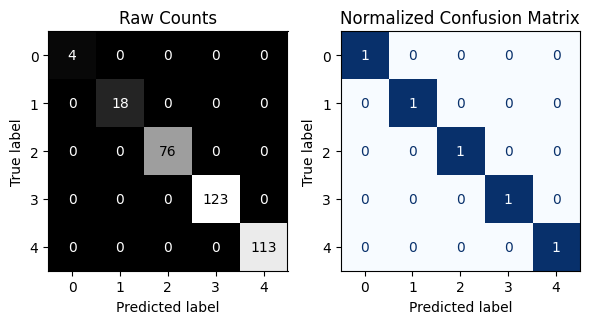


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.18      0.12      0.15        16
           3       0.42      0.56      0.48        32
           4       0.64      0.58      0.61        31

    accuracy                           0.45        84
   macro avg       0.25      0.25      0.25        84
weighted avg       0.43      0.45      0.44        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


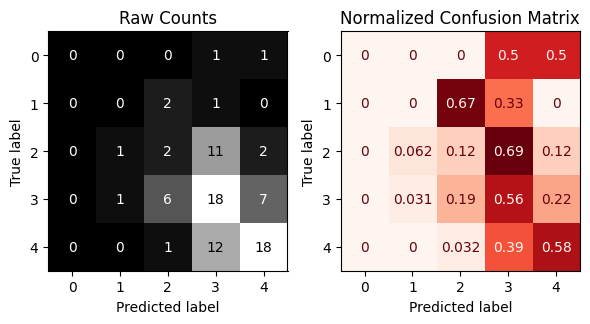

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# Create param grid with different values to try
params = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'leaf_size': [20,25,30,35],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

#Instantiate gridsearch
grid_search = GridSearchCV(knn, params, cv=5, verbose=True, n_jobs=-1)
# Fit gs on training data
grid_search.fit(X_train_processed, y_train)
# Obtain best param value for K
grid_search.best_params_

# Obtain complete evaluation for best performing model
evaluate_classification(grid_search.best_estimator_, X_train_processed, y_train, X_test_processed, y_test)

##Decision Tree

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00       123
           4       1.00      1.00      1.00       113

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



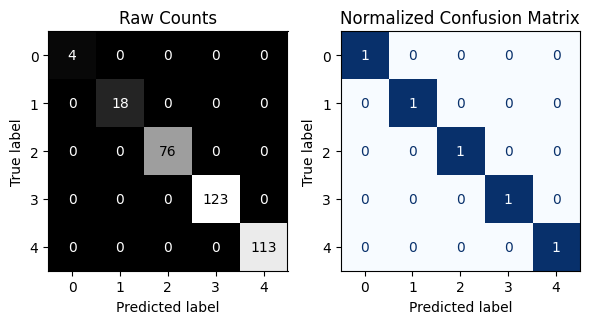


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.29      0.31      0.30        16
           3       0.42      0.50      0.46        32
           4       0.54      0.45      0.49        31

    accuracy                           0.42        84
   macro avg       0.25      0.25      0.25        84
weighted avg       0.42      0.42      0.41        84



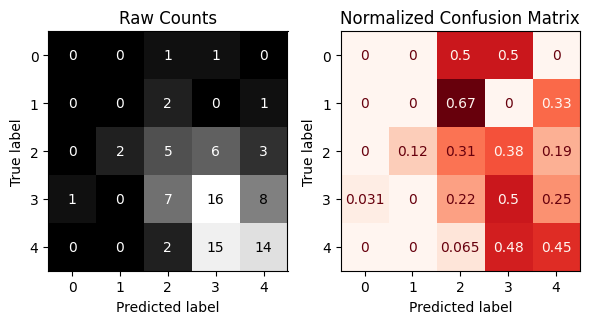

In [19]:
# Instantiate default Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_processed, y_train)
evaluate_classification(dt, X_train_processed, y_train, X_test_processed, y_test)

###Tuning





In [20]:
# Get list of params
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: Futu

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        18
           2       0.48      0.37      0.42        76
           3       0.50      0.67      0.58       123
           4       0.61      0.60      0.61       113

    accuracy                           0.54       334
   macro avg       0.32      0.33      0.32       334
weighted avg       0.50      0.54      0.51       334



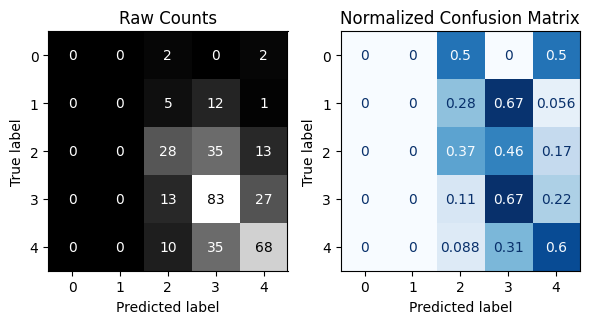

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.23      0.19      0.21        16
           3       0.43      0.59      0.50        32
           4       0.44      0.39      0.41        31

    accuracy                           0.40        84
   macro avg       0.22      0.23      0.22        84
weighted avg       0.37      0.40      0.38        84



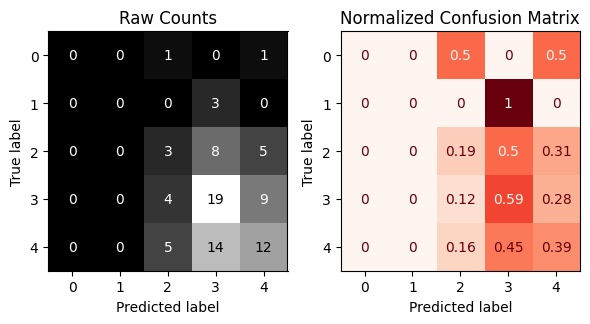

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Perform GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)
# Obtain best param value
grid_search.best_params_

# Obtain complete evaluation for best performing model
evaluate_classification(grid_search.best_estimator_, X_train_processed, y_train, X_test_processed, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        18
           2       0.48      0.37      0.42        76
           3       0.50      0.67      0.58       123
           4       0.61      0.60      0.61       113

    accuracy                           0.54       334
   macro avg       0.32      0.33      0.32       334
weighted avg       0.50      0.54      0.51       334



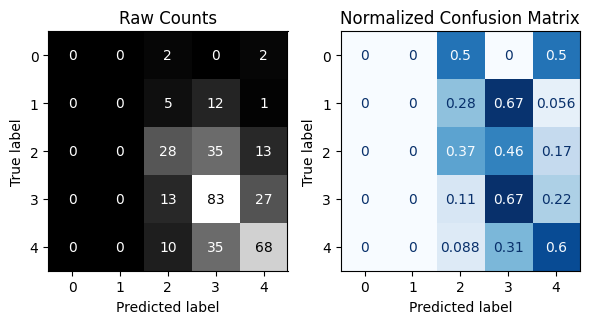

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.23      0.19      0.21        16
           3       0.43      0.59      0.50        32
           4       0.44      0.39      0.41        31

    accuracy                           0.40        84
   macro avg       0.22      0.23      0.22        84
weighted avg       0.37      0.40      0.38        84



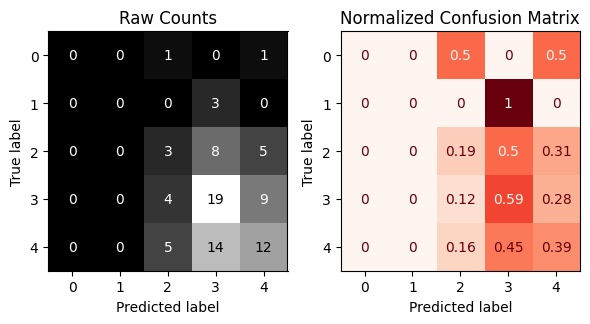

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Obtain complete evaluation for best performing model
evaluate_classification(grid_search.best_estimator_, X_train_processed, y_train, X_test_processed, y_test)

##Logistic Regression

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.50      0.06      0.10        18
           2       0.47      0.38      0.42        76
           3       0.55      0.63      0.59       123
           4       0.67      0.74      0.70       113

    accuracy                           0.58       334
   macro avg       0.64      0.41      0.44       334
weighted avg       0.57      0.58      0.56       334



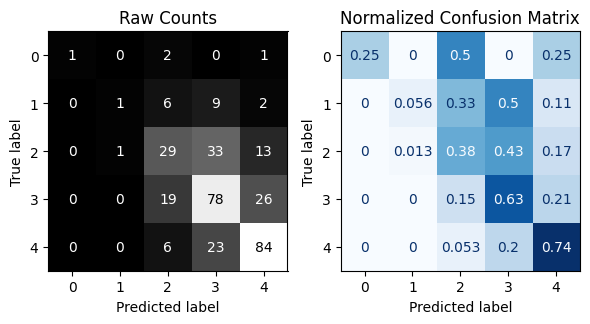


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.19      0.19      0.19        16
           3       0.51      0.56      0.54        32
           4       0.56      0.58      0.57        31

    accuracy                           0.46        84
   macro avg       0.25      0.27      0.26        84
weighted avg       0.44      0.46      0.45        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


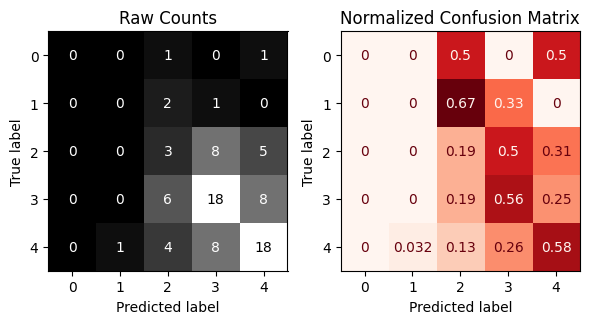

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Default logreg model
logreg = LogisticRegression(max_iter=500, random_state=42)
logreg.fit(X_train_processed, y_train)
evaluate_classification(logreg, X_train_processed, y_train, X_test_processed, y_test)

###Tuning

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check

Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'fit_intercept': False, 'max_iter': 1500, 'multi_class': 'auto', 'penalty': 'l2', 'warm_start': True}
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        18
           2       0.41      0.30      0.35        76
           3       0.52      0.63      0.57       123
           4       0.64      0.73      0.69       113

    accuracy                           0.55       334
   macro avg       0.32      0.33      0.32       334
weighted avg       0.50      0.55      0.52       334



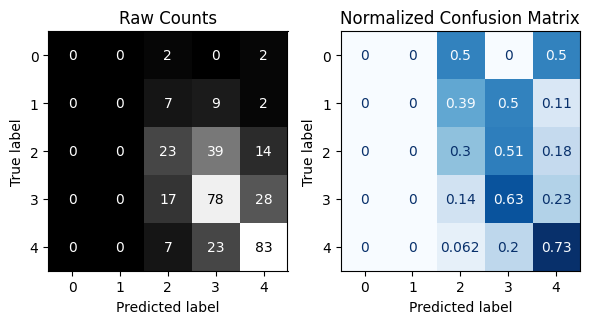

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.19      0.19      0.19        16
           3       0.46      0.53      0.49        32
           4       0.58      0.58      0.58        31

    accuracy                           0.45        84
   macro avg       0.25      0.26      0.25        84
weighted avg       0.43      0.45      0.44        84



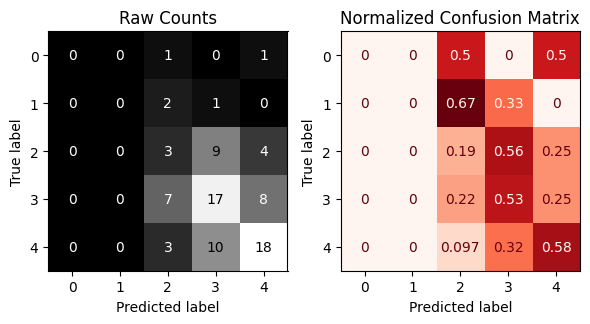

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Define a hyperparameter grid to search
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [1500],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Perform GridSearchCV
grid_search = GridSearchCV(logreg, params, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

# Print the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model from GridSearchCV
best_logreg_model = grid_search.best_estimator_

evaluate_classification(grid_search.best_estimator_, X_train_processed, y_train, X_test_processed, y_test)

#Applying PCA

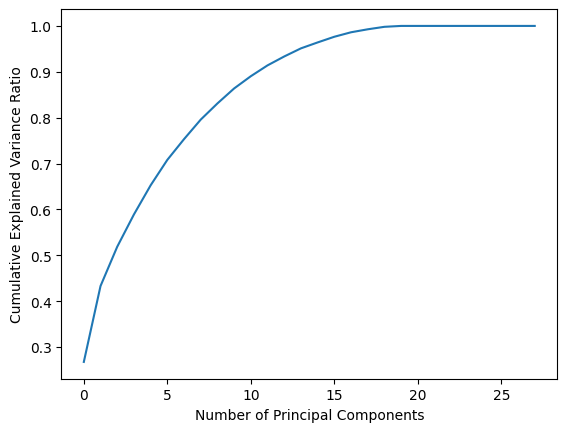

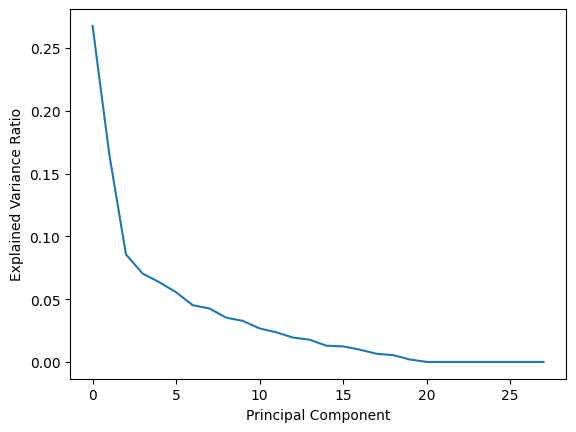

In [25]:
pca = PCA()
pca.fit(X_train_processed)  # X_train_scaled is your scaled data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()


plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()


In [26]:
# Apply PCA for dimensionality reduction with 6 components you want
pca = PCA(n_components=5)

# Transform your preprocessed training and testing data
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

In [27]:
X_train_pca

,pca0,pca1,pca2,pca3,pca4
336,-2.865145,0.651911,-0.334345,-0.129258,-0.186362
31,1.411238,-1.792927,-1.317258,1.312967,1.685333
84,0.308212,-0.423617,-0.951536,-0.459574,0.625387
287,1.603681,-0.001845,0.918160,-0.158751,-0.838245
317,-2.835225,-0.370926,1.471576,-0.161625,0.162725
...,...,...,...,...,...
71,0.030725,-2.298862,0.181912,-1.141291,-0.217908
106,-0.343377,-0.011933,-3.606754,-1.629650,3.149555
270,0.767485,-0.741150,0.466065,0.556403,-1.081574
348,-2.963637,-0.398966,-0.036946,-0.192464,0.488834


##KNN

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.67      0.22      0.33        18
           2       0.53      0.55      0.54        76
           3       0.55      0.71      0.62       123
           4       0.78      0.58      0.67       113

    accuracy                           0.60       334
   macro avg       0.50      0.41      0.43       334
weighted avg       0.62      0.60      0.59       334



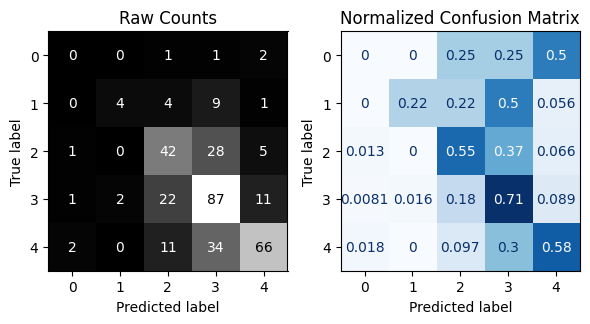


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.25      0.31      0.28        16
           3       0.39      0.53      0.45        32
           4       0.68      0.42      0.52        31

    accuracy                           0.42        84
   macro avg       0.26      0.25      0.25        84
weighted avg       0.45      0.42      0.42        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


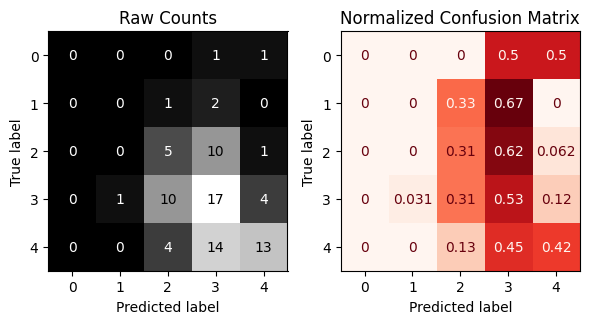

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Instantiate default KNN
knn = KNeighborsClassifier()

# Fit on PCA trained set
knn.fit(X_train_pca, y_train)
evaluate_classification(knn, X_train_pca, y_train, X_test_pca, y_test)

###Tuning With PCA

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 120 candidates, totalling 600 fits
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00       123
           4       1.00      1.00      1.00       113

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



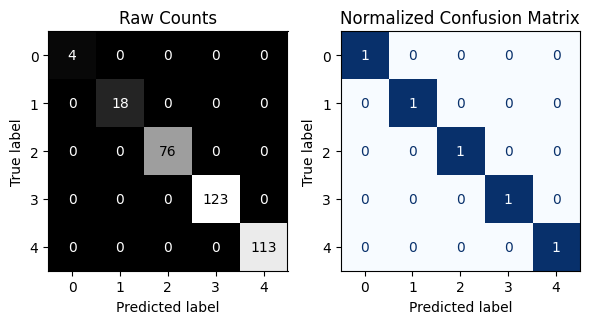


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.36      0.25      0.30        16
           3       0.43      0.59      0.50        32
           4       0.66      0.61      0.63        31

    accuracy                           0.50        84
   macro avg       0.29      0.29      0.29        84
weighted avg       0.48      0.50      0.48        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


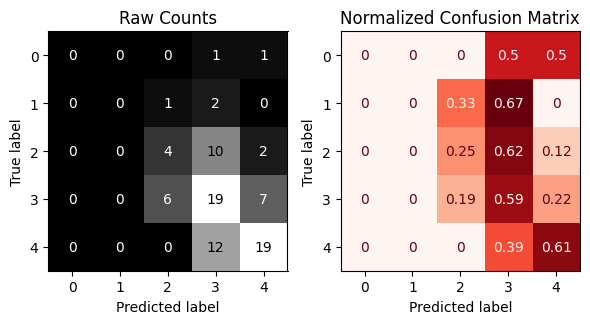

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Create param grid with different values to try
params = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'leaf_size': [20,25,30,35],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

#Instantiate gridsearch
grid_search = GridSearchCV(knn, params, cv=5, verbose=True, n_jobs=-1)
# Fit gs on training data
grid_search.fit(X_train_pca, y_train)
# Obtain best param value for K
grid_search.best_params_

# Obtain complete evaluation for best performing model
evaluate_classification(grid_search.best_estimator_, X_train_pca, y_train, X_test_pca, y_test)

##Decision Tree

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        76
           3       1.00      1.00      1.00       123
           4       1.00      1.00      1.00       113

    accuracy                           1.00       334
   macro avg       1.00      1.00      1.00       334
weighted avg       1.00      1.00      1.00       334



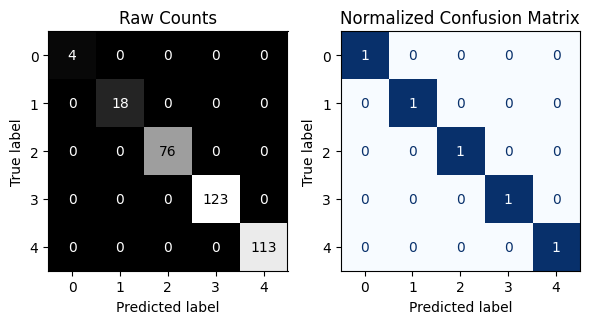


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.09      0.33      0.14         3
           2       0.07      0.06      0.07        16
           3       0.38      0.38      0.38        32
           4       0.56      0.48      0.52        31

    accuracy                           0.35        84
   macro avg       0.22      0.25      0.22        84
weighted avg       0.36      0.35      0.35        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


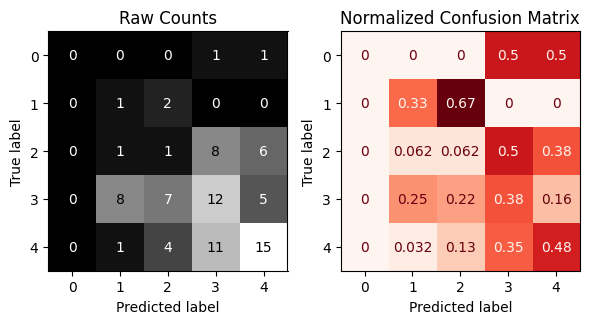

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Instantiate default model
dt = DecisionTreeClassifier()

# Fit on PCA trained set
dt.fit(X_train_pca, y_train)
evaluate_classification(dt, X_train_pca, y_train, X_test_pca, y_test)

###Tuning With PCA

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: Futu

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.44      0.44      0.44        18
           2       0.57      0.51      0.54        76
           3       0.67      0.66      0.66       123
           4       0.70      0.79      0.74       113

    accuracy                           0.65       334
   macro avg       0.48      0.48      0.48       334
weighted avg       0.64      0.65      0.64       334



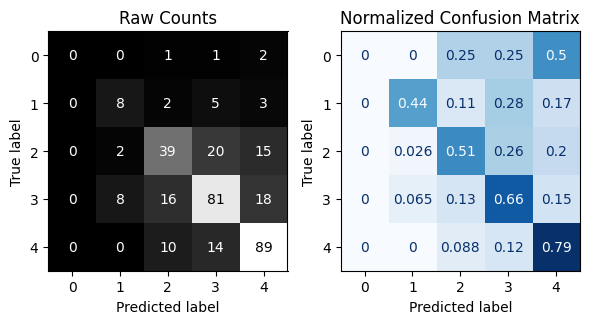

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.22      0.67      0.33         3
           2       0.33      0.25      0.29        16
           3       0.54      0.47      0.50        32
           4       0.54      0.61      0.58        31

    accuracy                           0.48        84
   macro avg       0.33      0.40      0.34        84
weighted avg       0.48      0.48      0.47        84



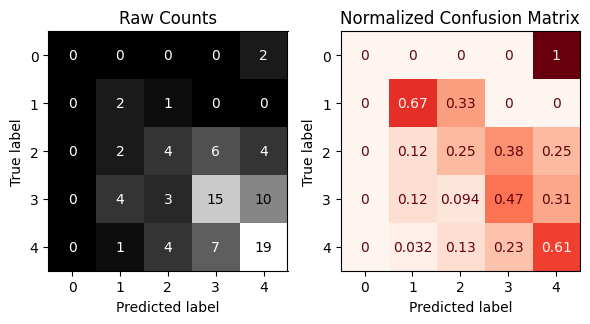

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Perform GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)
# Obtain best param value
grid_search.best_params_

# Obtain complete evaluation for best performing model
evaluate_classification(grid_search.best_estimator_, X_train_pca, y_train, X_test_pca, y_test)

##Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.00      0.00      0.00        18
           2       0.43      0.26      0.33        76
           3       0.49      0.67      0.57       123
           4       0.62      0.66      0.64       113

    accuracy                           0.53       334
   macro avg       0.51      0.37      0.39       334
weighted avg       0.50      0.53      0.51       334



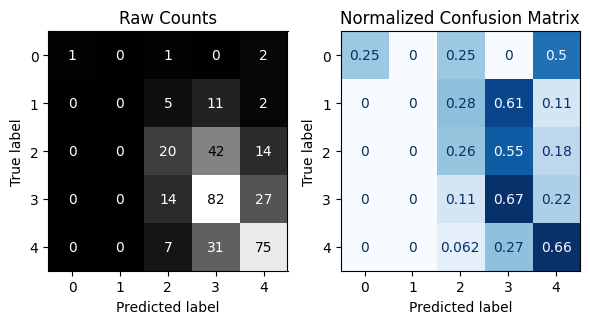

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.07      0.06      0.06        16
           3       0.42      0.47      0.44        32
           4       0.55      0.58      0.56        31

    accuracy                           0.40        84
   macro avg       0.21      0.22      0.21        84
weighted avg       0.37      0.40      0.39        84



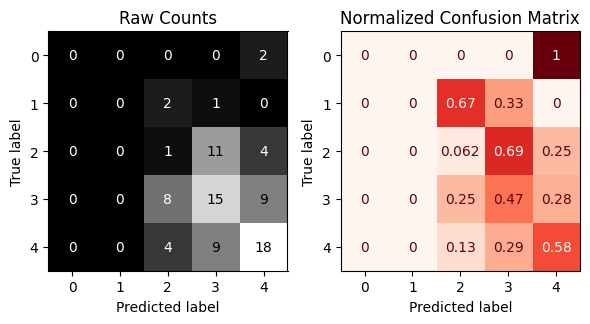

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Make an instance of the model with default parameters
logreg = LogisticRegression(max_iter=500, random_state=42)

#Fit on PCA set
logreg.fit(X_train_pca, y_train)
evaluate_classification(logreg, X_train_pca, y_train, X_test_pca, y_test)

###Tuning With PCA

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

Best Hyperparameters: {'C': 0.1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'multi_class': 'auto', 'penalty': 'l2', 'warm_start': True}
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        18
           2       0.43      0.25      0.32        76
           3       0.50      0.67      0.57       123
           4       0.62      0.68      0.65       113

    accuracy                           0.53       334
   macro avg       0.31      0.32      0.31       334
weighted avg       0.49      0.53      0.50       334



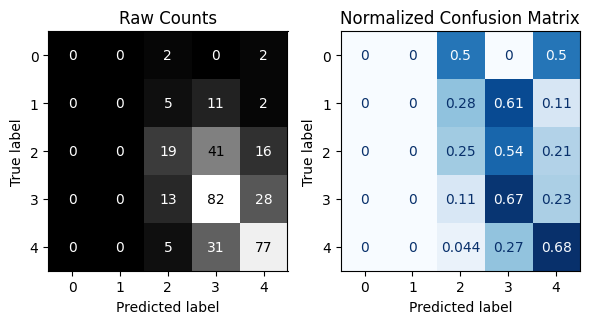

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         3
           2       0.07      0.06      0.06        16
           3       0.42      0.47      0.44        32
           4       0.55      0.58      0.56        31

    accuracy                           0.40        84
   macro avg       0.21      0.22      0.21        84
weighted avg       0.37      0.40      0.39        84



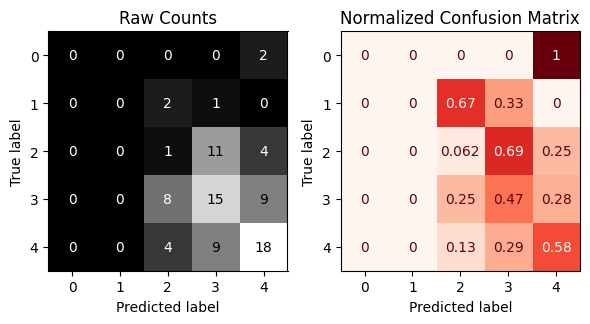

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Define a hyperparameter grid to search
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [50, 100, 200, 500, 1000],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Perform GridSearchCV
grid_search = GridSearchCV(logreg, params, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Print the best hyperparameters and corresponding accuracy
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model from GridSearchCV
best_logreg_model = grid_search.best_estimator_

evaluate_classification(grid_search.best_estimator_, X_train_pca, y_train, X_test_pca, y_test)

#Deep Learning

In [34]:
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [35]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# encode labels
encoder = LabelEncoder()

encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)

# make a record of the classes, in order of the encoding, in case we want to
# translate predictions into fish names later.
classes = encoder.classes_

# binarize labels
binarizer = LabelBinarizer()

binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)

# check results
print('Original Target')
print(y_train.head())

print('\nEncoded Target')
print(y_train_enc[:5])

print('\nBinarized Target')
print(y_train_bin[:5])

Original Target
336    0
31     4
84     4
287    2
317    2
Name: Stage, dtype: int64

Encoded Target
[0 4 4 2 2]

Binarized Target
[[1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                300       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
_________________________________________________________________


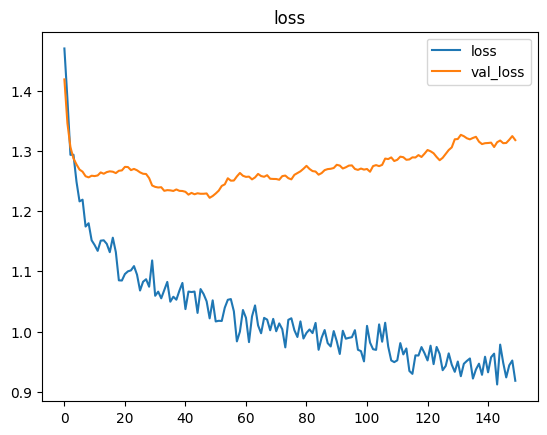

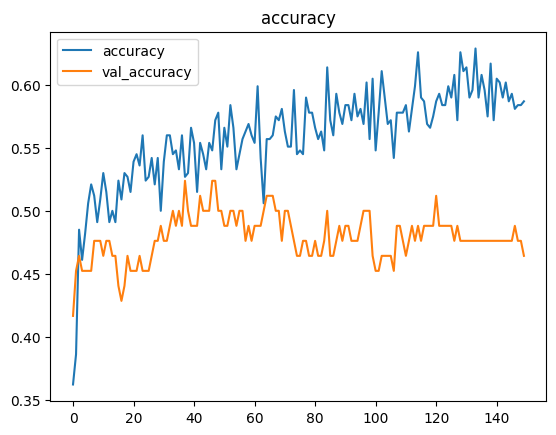

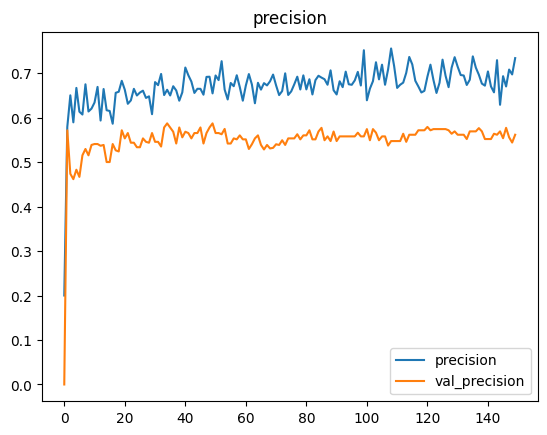

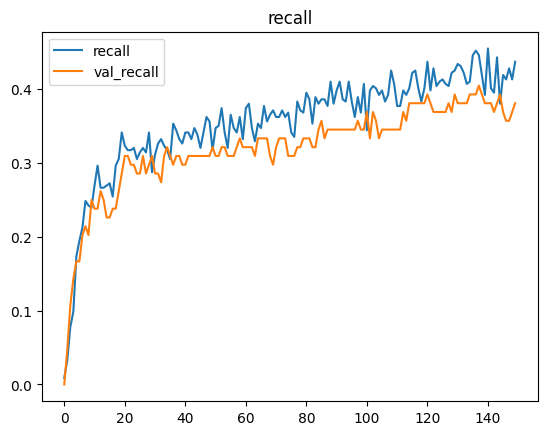

In [36]:
# create model architecture
input_dim = X_train_pca.shape[1]

num_classes = len(classes)

# instantiate the base model
multi_model = Sequential()

# add layers
multi_model.add(Dense(50, input_dim=input_dim, activation='relu'))
multi_model.add(Dropout(.3))
multi_model.add(Dense(50, activation='relu'))
multi_model.add(Dropout(.3))
multi_model.add(Dense(num_classes, activation='softmax'))
multi_model.summary()



# compile model with categorical_crossentropy

multi_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy',
                             metrics.Precision(),
                             metrics.Recall()])



# fit model

history = multi_model.fit(X_train_pca, y_train_bin,
                          validation_data=(X_test_pca, y_test_bin),
                          epochs=150,
                          verbose=0)

# plot learning

plot_history(history)

In [37]:
# get raw predictions
raw_pred = multi_model.predict(X_test_pca)

# display predictions and binarized true labels
print('Raw Predictions\n', raw_pred[:5])
print('\nbinarized y_test\n', y_test_bin[:5])

3/3 [==============================] - 0s 3ms/step
Raw Predictions
 [[2.3930302e-02 7.5648539e-03 1.7559478e-01 1.0491327e-01 6.8799675e-01]
 [3.1139476e-05 2.4545427e-01 1.4138548e-01 4.0487000e-03 6.0908049e-01]
 [1.3368636e-02 1.2737277e-02 1.5268762e-01 5.4442513e-01 2.7678132e-01]
 [3.5372192e-05 5.2993182e-02 4.8829271e-03 4.9119923e-01 4.5088938e-01]
 [3.4929445e-07 4.6659193e-06 5.1770452e-04 3.4015982e-03 9.9607563e-01]]

binarized y_test
 [[1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]]


In [38]:
# convert predictions and labels into integers representing each fish class.
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

print('integer predictions', y_pred)
print('integer true labels', y_true)

integer predictions [4 4 3 3 4 3 3 4 3 3 4 4 3 3 4 3 3 4 3 3 3 3 3 3 3 3 3 4 4 2 3 1 3 4 4 4 4
 3 3 4 2 3 2 3 3 3 4 3 4 3 4 4 3 4 2 3 4 3 3 4 3 3 3 3 4 2 3 4 4 3 4 3 2 4
 2 3 3 3 3 3 2 3 4 3]
integer true labels [0 2 4 3 3 2 1 4 3 3 4 3 3 4 3 4 3 4 2 3 4 4 3 4 3 3 3 4 2 3 3 4 2 4 4 3 4
 2 4 4 4 2 3 4 4 3 3 3 4 3 4 4 2 4 3 2 3 3 3 4 3 2 3 4 4 1 2 2 4 3 0 2 3 4
 3 3 4 4 2 1 2 2 4 3]


#Best Model


##KNN

The first KNN model, representing the default model, exhibits varying precision, recall, and F1-score across different classes, with class 4 showing the highest performance. The overall accuracy of the default model is 0.45, accompanied by a macro-average F1-score of 0.26 and a weighted-average F1-score of 0.44.

The second KNN model, fine-tuned through GridSearchCV, demonstrates slight enhancements in precision, recall, and F1-score compared to the default model, with class 4 displaying a relatively better performance. Despite these improvements, the accuracy and F1-scores remain consistent at 0.45.

Lastly, the third KNN model reflects performance after applying Principal Component Analysis (PCA), maintaining a similar pattern of class-specific metrics, where class 4 continues to exhibit notable recall and F1-score. The overall accuracy and F1-scores is consistent with those of the previous models.



##Decision Tree

 The first Decision Tree model, is the default model with class 4 displaying the highest performance. The overall accuracy of the default model stands at 0.43, accompanied by a macro-average F1-score of 0.26 and a weighted-average F1-score of 0.43.

 The second Decision Tree model, fine-tuned through optimization techniques, displays slight improvemnts in precision, recall, and F1-score, particularly in classes 2 and 4. However, the accuracy and F1-scores experience a decrease, with a score of 0.37.

 Lastly, the third Decision Tree model reveals performance for the Principal Component Analysis (PCA) for dimensionality reduction. While class metrics were comparable, the overall accuracy and F1-scores, at 0.36, consistently reflect the results of the previous models.Despite variations in class-specific metrics, the overall accuracy and F1-scores remain relatively consistent, signifying the potential for further exploration to enhance the models' performance on the provided dataset.

##Logistic Regression

 The first Logistic Regression model is the default, with class 4 displaying the highest performance. The overall accuracy of the default model stands at 0.46, accompanied by a macro-average F1-score of 0.26 and a weighted-average F1-score of 0.45.


 The second Logistic Regression model, optimized through tuning efforts, showcases slight enhancements in precision, recall, and F1-score, notably in classes 3 and 4. The accuracy and F1-scores remain consistent at 0.45.


 Lastly, the third Logistic Regression model after the application of Principal Component Analysis (PCA) for dimensionality reduction. While metrics exhibit a similar results, the overall accuracy and F1-scores, at 0.43, consistently mirror the results of the previous models.


#Recommended Model

Based on the provided summaries of the models, it appears that the KNN Modek that was tuned with 6 PCA components appears to have been the best model with an accuracy score of 0.50.
